In [73]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import spacy
from scipy.special import expit as sigmoid
from scipy.stats import pearsonr

import dianna
from dianna import visualization
from dianna import utils
from dianna.utils.tokenizers import SpacyTokenizer

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F

from torchtext.vocab import Vectors
from torchtext.data import get_tokenizer

import tqdm
import wandb

# ensure the tokenizer for english is available
spacy.cli.download('en_core_web_sm')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 6.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
# mode = 'online'
mode = 'disabled'
wandb.init(project='movie-reviews', entity='dianna-ai', mode=mode)

# tunable hyperparameters
config = wandb.config
config.batch_size = 64
config.epochs = 10
config.output_dim = 1
config.dropout = .4
config.n_filters = 128
config.filter_sizes = [3, 4, 5]
config.learning_rate = 0.001
config.weight_decay = 0.0003
config.max_samples = 10000  # maximum samples of training set to use

# select device to run on
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'PyTorch will use {device}')

# path to data files
data_path = 'model/'

# tokenizer for splitting input sentences
tokenizer = get_tokenizer('spacy', 'en_core_web_sm')

# word vectors as generated from data preparation notebook
vocab = Vectors('word_vectors.txt', cache='.')

# class to hold a dataset
# custom datasets need to implement init, len, and getitem
class MovieReviewDataset(Dataset):
    def __init__(self, filename, tokenizer, vocab, max_samples=None, max_filter_size=None):
        self.tokenizer = tokenizer
        self.vocab = vocab
        self.max_filter_size = max_filter_size

        self.data = pd.read_csv(filename, delimiter='\t')
        if max_samples is not None:
            self.data = self.data[:min(len(self.data), max_samples)]
          
    def __getitem__(self, idx):
        # get sentence and corresponding label
        sentence = self.data.iloc[idx]['sentence']
        label = self.data.iloc[idx]['label']
        # tokenize sentence
        tokens = self.tokenizer(sentence)
        # pad if needed
        if self.max_filter_size is not None:
            tokens = pad(tokens, self.max_filter_size)
        # numericalize
        tokens_numerical = [self.vocab.stoi[token] if token in self.vocab.stoi else self.vocab.stoi['<unk>'] for token in tokens]
        return tokens_numerical, label
    
    def __len__(self):
        return len(self.data)
    
# function to pad to some minimum length
def pad(tokens, max_filter_size, padding_token='<pad>'):
    npad = max(max_filter_size - len(tokens), 0)
    tokens += [padding_token] * npad
    return tokens

# custom collate function to handle variable-size input
def collate(batch, padding_idx):
    # get max sample size: item[0] is the input sentence split into numerical tokens
    tokens = [sample[0] for sample in batch]
    max_size = max(map(len, tokens))
    # create input array with padding such that each element has the same size
    input_data = np.empty((len(batch), max_size), dtype=int)
    for i, item in enumerate(tokens):
        # pad each element and store
        input_data[i] = pad(item, max_size, padding_token=padding_idx)

    # convert to tensors
    input_data = torch.LongTensor(input_data)
    labels = torch.FloatTensor([item[1] for item in batch])
    return [input_data, labels]

# convert collate function to callable that only requires batch as argument
collate_func = lambda batch: collate(batch, vocab.stoi['<pad>'])

# Load data into PyTorch dataset
# These datasets return the input as numerical values, suited for input to the model

train_data = MovieReviewDataset(os.path.join(data_path, 'train.tsv'), tokenizer, vocab, max_samples=config.max_samples)
val_data = MovieReviewDataset(os.path.join(data_path, 'validation.tsv'), tokenizer, vocab)

# Create iterators for the data
batch_size = config.batch_size
nworker = min(12, os.cpu_count() - 1)

train_data_iterator = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_func, num_workers=nworker, pin_memory=True)
val_data_iterator = DataLoader(val_data, batch_size=batch_size, shuffle=True, collate_fn=collate_func, num_workers=nworker, pin_memory=True)

# create a model
class Model(nn.Module):
    def __init__(self, vocab_size, embedding_size, n_filters, filter_sizes, padding_idx,
                dropout, output_dim):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=padding_idx)
        
        self.conv_layers = nn.ModuleList()
        for filter_size in filter_sizes:
            layer = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_size, embedding_size))
            self.conv_layers.append(layer)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(n_filters * len(filter_sizes), output_dim)
    
    def forward(self, text):
        # shape = [batch size, max nword per sentence]
        embedding = self.embedding(text).unsqueeze(1)
        # shape = [batch_size, 1, nword, embedding dim]
        conved = [F.relu(conv(embedding)).squeeze(3) for conv in self.conv_layers]
        # shape = len(filter_sizes) list of [batch_size, n_filter, nword - filter_size + 1]
        # note: max_pool1d does not work with ONNX when output shape is dynamic
        # therefore switched to adaptive_max_pool1d
        pooled = [F.adaptive_max_pool1d(out, 1).squeeze(2) for out in conved]
        # shape = len(filter_sizes) list of [batch_size, n_filter]
        concat = torch.cat(pooled, dim=1)
        # shape = [batch_size * len(filter_sizes), n_filter]
        dropped = self.dropout(concat)
        return self.fc(dropped)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


PyTorch will use cpu


In [5]:
# init a model
output_dim = config.output_dim
dropout = config.dropout
n_filters = config.n_filters
filter_sizes = config.filter_sizes

vocab_size, embedding_size = vocab.vectors.size()
padding_idx = vocab.stoi['<pad>']

model = Model(vocab_size, embedding_size, n_filters, filter_sizes, padding_idx, dropout, output_dim)
# copy pre-trained embeddings into model
model.embedding.weight.data.copy_(vocab.vectors)

model = model.to(device)

wandb.watch(model)

# Define training and evaluation functions
# first define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
loss_func = nn.BCEWithLogitsLoss().to(device)

# function to calculate accuracy
def accuracy(model_output, y_true):
    y_pred = torch.round(torch.sigmoid(model_output))
    return (y_pred == y_true).sum() / len(y_pred)

def train(model, train_data, optimizer, loss_func):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for batch in tqdm.tqdm(train_data, file=sys.stdout):
        input_data, label = batch
        input_data = input_data.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        predictions = model(input_data).squeeze(1)
        
        loss = loss_func(predictions, label)
        acc = accuracy(predictions, label)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        wandb.log({'train_loss': loss.item(), 'train_acc': acc.item()})
        
    epoch_loss /= len(train_data)
    epoch_acc /= len(train_data)
    
    wandb.log({'train_epoch_loss': epoch_loss, 'train_epoch_acc': epoch_acc})
                
    return epoch_loss, epoch_acc

def evaluate(model, data, loss_func):
    loss = 0
    acc = 0
    model.eval()
    
    with torch.no_grad():
        for batch in data:
            input_data, label = batch
            input_data = input_data.to(device)
            label = label.to(device)
            predictions = model(input_data).squeeze(1)

            loss += loss_func(predictions, label).item()
            acc += accuracy(predictions, label).item()
            
    loss /= len(data)
    acc /= len(data)
        
    return loss, acc

# do the training
best_val_loss = np.inf
best_val_acc = np.inf

for epoch in range(config.epochs):
    train_epoch_loss, train_epoch_acc = train(model, train_data_iterator, optimizer, loss_func)
    val_epoch_loss, val_epoch_acc = evaluate(model, val_data_iterator, loss_func)
    # log the validation results to wandb
    wandb.log({'val_epoch_loss': val_epoch_loss, 'val_epoch_acc': val_epoch_acc})
    print(f'train loss: {train_epoch_loss:.2f} | train acc: {train_epoch_acc:.2f}')
    print(f'val   loss: {val_epoch_loss:.2f} | val   acc: {val_epoch_acc:.2f}')
    # store model with best validation loss
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        best_val_acc = val_epoch_acc
        # ensure we are in eval mode
        model.eval()
        torch.save(model, 'movie_review_model.pytorch')

print(f"Best validation loss: {best_val_loss:.2f}, accuracy: {best_val_acc:.2f}")


# load best model from disk
loaded_model = torch.load('movie_review_model.pytorch')
loaded_model = loaded_model.to(device)
loaded_model.eval()

# store as ONNX, needs example input
x = next(iter(train_data_iterator))[0].to(device)
torch.onnx.export(loaded_model, x, 'movie_review_model.onnx', opset_version=11,
                  export_params=True, input_names=['input'], output_names=['output'],
                  dynamic_axes={'input': {0: 'batch_size', 1: 'sentence_length'},
                                'output': {0: 'batch_size'}})

# class to predict sentiment from a sentence
class Predictor:
    def __init__(self, model, tokenizer, vocab, device, max_filter_size=None):
        self.model = model
        self.tokenizer = tokenizer
        self.vocab = vocab
        self.device = device
        self.max_filter_size = max_filter_size
        self.classes = ['negative', 'positive']
        
        self.model.eval()
        
    def __call__(self, sentence):
        # get numerical tokens
        tokens = tokenizer(sentence)
        # pad if needed
        if self.max_filter_size is not None:
            tokens = pad(tokens, self.max_filter_size)
        # numericalize
        tokens = [self.vocab.stoi[token] if token in self.vocab.stoi else self.vocab.stoi['<unk>'] for token in tokens]
        # move to device and add required batch axis
        tokens = torch.tensor(tokens).unsqueeze(0).to(self.device)
        # feed to model
        pred = torch.sigmoid(model.forward(tokens)).item()
        # get string representation of predicted class
        class_str = self.classes[int(np.round(pred))]
        
        return pred, class_str
    
predict_sentiment = Predictor(loaded_model, tokenizer, vocab, device, max_filter_size=max(config.filter_sizes))


100%|██████████| 157/157 [00:05<00:00, 28.84it/s]
train loss: 0.51 | train acc: 0.75
val   loss: 0.46 | val   acc: 0.79
100%|██████████| 157/157 [00:05<00:00, 30.02it/s]
train loss: 0.34 | train acc: 0.86
val   loss: 0.42 | val   acc: 0.80
100%|██████████| 157/157 [00:05<00:00, 30.26it/s]
train loss: 0.26 | train acc: 0.90
val   loss: 0.42 | val   acc: 0.81
100%|██████████| 157/157 [00:05<00:00, 30.20it/s]
train loss: 0.20 | train acc: 0.93
val   loss: 0.46 | val   acc: 0.80
100%|██████████| 157/157 [00:05<00:00, 27.99it/s]
train loss: 0.15 | train acc: 0.95
val   loss: 0.47 | val   acc: 0.80
100%|██████████| 157/157 [00:05<00:00, 28.68it/s]
train loss: 0.12 | train acc: 0.96
val   loss: 0.48 | val   acc: 0.79
100%|██████████| 157/157 [00:05<00:00, 29.16it/s]
train loss: 0.10 | train acc: 0.97
val   loss: 0.58 | val   acc: 0.77
100%|██████████| 157/157 [00:05<00:00, 28.75it/s]
train loss: 0.09 | train acc: 0.98
val   loss: 0.57 | val   acc: 0.78
100%|██████████| 157/157 [00:05<00:00, 3

In [88]:
model_path = Path('model', 'movie_review_model.onnx')
word_vector_path = Path('', 'word_vectors.txt')
labels = ("negative", "positive")

class MovieReviewsModelRunner:
    def __init__(self, model, word_vectors, max_filter_size):
        self.run_model = utils.get_function(model)
        self.vocab = Vectors(word_vectors, cache=os.path.dirname(word_vectors))
        self.max_filter_size = max_filter_size

        self.tokenizer = SpacyTokenizer(name='en_core_web_sm')

    def __call__(self, sentences):
        # ensure the input has a batch axis
        if isinstance(sentences, str):
            sentences = [sentences]

        output = []
        for sentence in sentences:
            # tokenize and pad to minimum length
            tokens = self.tokenizer.tokenize(sentence)
            if len(tokens) < self.max_filter_size:
                tokens += ['<pad>'] * (self.max_filter_size - len(tokens))

            # numericalize the tokens
            tokens_numerical = [self.vocab.stoi[token] if token in self.vocab.stoi else self.vocab.stoi['<unk>']
                                for token in tokens]

            # run the model, applying a sigmoid because the model outputs logits, remove any remaining batch axis
            pred = float(sigmoid(self.run_model([tokens_numerical])))
            output.append(pred)

        # output two classes
        positivity = np.array(output)
        negativity = 1 - positivity
        return np.transpose([negativity, positivity])

# define model runner. max_filter_size is a property of the model
model_runner = MovieReviewsModelRunner(model_path, word_vector_path, max_filter_size=5)

In [90]:
# print some predictions/explanations from the (unlabeled) experiment set for the workshop
sentences1 = pd.read_csv(os.path.join(data_path, 'experiment1.tsv'), delimiter='\t')['sentence1']
sentences2 = pd.read_csv(os.path.join(data_path, 'experiment2.tsv'), delimiter='\t')['sentence2']
sentences3 = pd.read_csv(os.path.join(data_path, 'experiment3.tsv'), delimiter='\t')['sentence3']
score = pd.read_csv(os.path.join(data_path, 'wordscore.tsv'), delimiter='\t')['score']
wordscore=[]
perturbation1=[]
perturbation2=[]
perturbation3=[]
nmax = 51
classes = ['negative', 'positive']

for n, (sentence1,sentence2,sentence3) in enumerate(zip(sentences1,sentences2,sentences3)):
    if n == nmax:
        break
    output_numerical, predicted_class = predict_sentiment(sentence1)
    print(f"\"{sentence1}\" - {predicted_class} - {output_numerical:.2f}")

    wordscore.append((score[n]-1)/24)
    
    explanation_relevance1 = dianna.explain_text(model_runner, sentence1, model_runner.tokenizer,'RISE', labels=[labels.index('positive')])[0]

    perturbation1.append(explanation_relevance1[2][2])

    for i in range(len(explanation_relevance1)):
        explanation_relevance1[i] = (explanation_relevance1[i][0],explanation_relevance1[i][1],((2*(explanation_relevance1[i][2]))-1))

    print(explanation_relevance1)

    visualization.highlight_text(explanation_relevance1, model_runner.tokenizer.tokenize(sentence1))

    output_numerical, predicted_class = predict_sentiment(sentence2)
    print(f"\"{sentence2}\" - {predicted_class} - {output_numerical:.2f}")

    explanation_relevance2 = dianna.explain_text(model_runner, sentence2, model_runner.tokenizer,'RISE', labels=[labels.index('positive')])[0]

    perturbation2.append(explanation_relevance2[2][2])

    for i in range(len(explanation_relevance2)):
        explanation_relevance2[i] = (explanation_relevance2[i][0],explanation_relevance2[i][1],((2*(explanation_relevance2[i][2]))-1))

    print(explanation_relevance2)

    visualization.highlight_text(explanation_relevance2, model_runner.tokenizer.tokenize(sentence2))

    output_numerical, predicted_class = predict_sentiment(sentence3)
    print(f"\"{sentence3}\" - {predicted_class} - {output_numerical:.2f}")

    explanation_relevance3 = dianna.explain_text(model_runner, sentence3, model_runner.tokenizer,'RISE', labels=[labels.index('positive')])[0]

    perturbation3.append(explanation_relevance3[1][2])

    for i in range(len(explanation_relevance3)):
        explanation_relevance3[i] = (explanation_relevance3[i][0],explanation_relevance3[i][1],((2*(explanation_relevance3[i][2]))-1))

    print(explanation_relevance3)

    visualization.highlight_text(explanation_relevance3, model_runner.tokenizer.tokenize(sentence3))

"It is worthless." - negative - 0.07
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]

[('It', 0, -0.4366016015633941), ('is', 1, -0.40447407534718516), ('worthless', 2, -0.9299311614483595), ('.', 3, -0.46943103335797787)]


"This is worthless." - negative - 0.07
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('This', 0, -0.40201239395141597), ('is', 1, -0.3551179520785809), ('worthless', 2, -0.9292916301712394), ('.', 3, -0.4874757638499141)]


"A worthless film." - negative - 0.00
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.10s/it]

[('A', 0, -0.4156136345788837), ('worthless', 1, -0.9486930836215616), ('film', 2, -0.3913904095441103), ('.', 3, -0.4634366471618414)]


"It is dreadful." - negative - 0.28
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('It', 0, -0.31877372067421683), ('is', 1, -0.19419696673750886), ('dreadful', 2, -0.7866624000668525), ('.', 3, -0.37349612995982173)]


"This is dreadful." - negative - 0.28
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.10s/it]

[('This', 0, -0.4068762520253658), ('is', 1, -0.32705054146051404), ('dreadful', 2, -0.7751517668962479), ('.', 3, -0.42160856419801707)]


"A dreadful film." - negative - 0.02
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('A', 0, -0.38306503331661224), ('dreadful', 1, -0.8917424947917462), ('film', 2, -0.34042065638303753), ('.', 3, -0.3899522876143455)]


"It is irritating." - negative - 0.03
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('It', 0, -0.23366592843085532), ('is', 1, -0.1506585938483478), ('irritating', 2, -0.7978219364583492), ('.', 3, -0.3263927969336511)]


"This is irritating." - negative - 0.03
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]

[('This', 0, -0.4816540983319282), ('is', 1, -0.42936326563358307), ('irritating', 2, -0.7740206634998321), ('.', 3, -0.46182590499520304)]


"An irritating film." - negative - 0.00
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]

[('An', 0, -0.30457113809883596), ('irritating', 1, -0.8526143498346209), ('film', 2, -0.19717913977801804), ('.', 3, -0.3364005502685904)]


"It is horrible." - negative - 0.04
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]

[('It', 0, -0.31647443644702444), ('is', 1, -0.2483784096688032), ('horrible', 2, -0.8603572754189373), ('.', 3, -0.2890772118419409)]


"This is horrible." - negative - 0.04
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]

[('This', 0, -0.4226256225705147), ('is', 1, -0.3583358275294304), ('horrible', 2, -0.8485202154517174), ('.', 3, -0.4261295092701912)]


"A horrible film." - negative - 0.00
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]

[('A', 0, -0.4712480494305491), ('horrible', 1, -0.9332084762528539), ('film', 2, -0.38669124875962735), ('.', 3, -0.42737237056344746)]


"It is excruciating." - positive - 0.64
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]

[('It', 0, -0.3336922323703765), ('is', 1, -0.28867802376548446), ('excruciating', 2, -0.6450964330633482), ('.', 3, -0.34967861215273544)]


"This is excruciating." - positive - 0.64
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]

[('This', 0, -0.38464820792277654), ('is', 1, -0.30947266956170394), ('excruciating', 2, -0.6141540696720282), ('.', 3, -0.4258561225732167)]


"An excruciating film." - negative - 0.20
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]

[('An', 0, -0.2950399668812752), ('excruciating', 1, -0.7731300805211068), ('film', 2, -0.20999917513132094), ('.', 3, -0.34963553661108016)]


"It is pointless." - negative - 0.02
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:12<00:00,  1.28s/it]

[('It', 0, -0.49662490761280065), ('is', 1, -0.3912676422297955), ('pointless', 2, -0.9156371515989303), ('.', 3, -0.4484106939435005)]


"This is pointless." - negative - 0.02
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]

[('This', 0, -0.528559916789333), ('is', 1, -0.4768288681159416), ('pointless', 2, -0.9142502177879215), ('.', 3, -0.5801935824751854)]


"A pointless film." - negative - 0.00
Rise parameter p_keep was automatically determined at 0.7000000000000001


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]

[('A', 0, -0.6392530856494394), ('pointless', 1, -0.9453177312814763), ('film', 2, -0.6107589562503355), ('.', 3, -0.6360311139055661)]


"It is bad." - negative - 0.22
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]

[('It', 0, -0.38789894380606715), ('is', 1, -0.30166142579168076), ('bad', 2, -0.9333813055604696), ('.', 3, -0.375554912686348)]


"This is bad." - negative - 0.22
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]

[('This', 0, -0.4548339876160026), ('is', 1, -0.4136258291304111), ('bad', 2, -0.9335249367281795), ('.', 3, -0.4996573806032538)]


"A bad film." - negative - 0.01
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]

[('A', 0, -0.5487293039107074), ('bad', 1, -0.9643158856965601), ('film', 2, -0.4745938993493716), ('.', 3, -0.5216037066963812)]


"It is depressing." - negative - 0.06
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.10s/it]

[('It', 0, -0.4088565389811992), ('is', 1, -0.3179933330913385), ('depressing', 2, -0.7316435200472673), ('.', 3, -0.4360773496329784)]


"This is depressing." - negative - 0.06
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.10s/it]

[('This', 0, -0.37622533674041425), ('is', 1, -0.3127923503518104), ('depressing', 2, -0.7338402277231216), ('.', 3, -0.42537329713503524)]


"A depressing film." - negative - 0.00
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.10s/it]

[('A', 0, -0.3957322856485843), ('depressing', 1, -0.8615940620005131), ('film', 2, -0.34725486767292024), ('.', 3, -0.4434951861202717)]


"It is nasty." - negative - 0.05
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]

[('It', 0, -0.38396763032674786), ('is', 1, -0.299436714142561), ('nasty', 2, -0.8886818729490041), ('.', 3, -0.41791038528084756)]


"This is nasty." - negative - 0.05
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]

[('This', 0, -0.43160749974846835), ('is', 1, -0.3315479650497436), ('nasty', 2, -0.8847531419694423), ('.', 3, -0.4291301057040692)]


"A nasty film." - negative - 0.00
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]

[('A', 0, -0.38973676887899633), ('nasty', 1, -0.9357434278130531), ('film', 2, -0.33066530680656436), ('.', 3, -0.4248967377245426)]


"It is boring." - negative - 0.03
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]

[('It', 0, -0.40978960967063904), ('is', 1, -0.286978347286582), ('boring', 2, -0.8925187194794416), ('.', 3, -0.46282691670954224)]


"This is boring." - negative - 0.03
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('This', 0, -0.3977475035339594), ('is', 1, -0.3262831280380487), ('boring', 2, -0.884499710559845), ('.', 3, -0.46183088767528535)]


"A boring film." - negative - 0.00
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('A', 0, -0.375749053016305), ('boring', 1, -0.9155821476131678), ('film', 2, -0.29518008136749263), ('.', 3, -0.4592516323924065)]


"It is lackluster." - negative - 0.20
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('It', 0, -0.39007087637980775), ('is', 1, -0.3504535802702109), ('lackluster', 2, -0.6788488091528415), ('.', 3, -0.37249092578887943)]


"This is lackluster." - negative - 0.20
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]

[('This', 0, -0.3311270412802696), ('is', 1, -0.20382313984632494), ('lackluster', 2, -0.6972160270810127), ('.', 3, -0.3706328169107437)]


"A lackluster film." - negative - 0.01
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('A', 0, -0.2714905395358802), ('lackluster', 1, -0.8177198138087988), ('film', 2, -0.17400155052542687), ('.', 3, -0.30968889515846976)]


"It is repetitive." - negative - 0.03
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]

[('It', 0, -0.47051779727141063), ('is', 1, -0.41418732325235996), ('repetitive', 2, -0.8919537229215105), ('.', 3, -0.5291930280625821)]


"This is repetitive." - negative - 0.03
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('This', 0, -0.40724068985879425), ('is', 1, -0.4018308272361756), ('repetitive', 2, -0.8876186629384756), ('.', 3, -0.46887676906585696)]


"A repetitive film." - negative - 0.00
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('A', 0, -0.4184443663060665), ('repetitive', 1, -0.9120571045279503), ('film', 2, -0.33809907448291776), ('.', 3, -0.45648238354921344)]


"It is worse." - negative - 0.11
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('It', 0, -0.5313824274142583), ('is', 1, -0.4840561834474404), ('worse', 2, -0.9351127801587185), ('.', 3, -0.5303996275365352)]


"This is worse." - negative - 0.11
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('This', 0, -0.40010637934505944), ('is', 1, -0.34980826967954637), ('worse', 2, -0.9380843526422977), ('.', 3, -0.41060707014799114)]


"A worse film." - negative - 0.00
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.10s/it]

[('A', 0, -0.4663304565548897), ('worse', 1, -0.9694315402731299), ('film', 2, -0.4211237958967685), ('.', 3, -0.480068795658648)]


"It is pitiful." - positive - 0.70
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]

[('It', 0, -0.39360731509327884), ('is', 1, -0.36069670006632804), ('pitiful', 2, -0.8109870368540287), ('.', 3, -0.4320970620512963)]


"This is pitiful." - positive - 0.70
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]

[('This', 0, -0.35927827319502825), ('is', 1, -0.2710566383302212), ('pitiful', 2, -0.8182070947289467), ('.', 3, -0.40801381886005406)]


"A pitiful film." - negative - 0.32
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('A', 0, -0.44336757485568523), ('pitiful', 1, -0.9078815697282553), ('film', 2, -0.29738121756911273), ('.', 3, -0.4317498849183321)]


"It is clunky." - negative - 0.06
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]

[('It', 0, -0.5489149409160018), ('is', 1, -0.49777717705816027), ('clunky', 2, -0.9362555553143224), ('.', 3, -0.5628882224112749)]


"This is clunky." - negative - 0.06
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]

[('This', 0, -0.43730257536470885), ('is', 1, -0.39507900048792366), ('clunky', 2, -0.93604266859591), ('.', 3, -0.5104150776118039)]


"A clunky film." - negative - 0.00
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]

[('A', 0, -0.44409052487462763), ('clunky', 1, -0.9563797298595309), ('film', 2, -0.4038428891822696), ('.', 3, -0.4870385916531086)]


"It is rotten." - negative - 0.03
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('It', 0, -0.3944862638711929), ('is', 1, -0.3892551938593387), ('rotten', 2, -0.904867695003748), ('.', 3, -0.5106494319438935)]


"This is rotten." - negative - 0.03
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('This', 0, -0.37194740766659373), ('is', 1, -0.29647404842078684), ('rotten', 2, -0.9058047783374786), ('.', 3, -0.3762159506604076)]


"A rotten film." - negative - 0.00
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.10s/it]

[('A', 0, -0.5166448845776419), ('rotten', 1, -0.9495257676703235), ('film', 2, -0.45780256360148386), ('.', 3, -0.5524256457388401)]


"It is tedious." - negative - 0.01
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]

[('It', 0, -0.4532922474592924), ('is', 1, -0.3642891137599945), ('tedious', 2, -0.8921097474396229), ('.', 3, -0.44094455124437804)]


"This is tedious." - negative - 0.01
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]

[('This', 0, -0.5067074688027302), ('is', 1, -0.4829297636697689), ('tedious', 2, -0.8882966681321461), ('.', 3, -0.550378839969635)]


"A tedious film." - negative - 0.00
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]

[('A', 0, -0.4189617625176907), ('tedious', 1, -0.925946235165), ('film', 2, -0.35858553312718866), ('.', 3, -0.4608021201491356)]


"It is cliched." - negative - 0.11
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]

[('It', 0, -0.3947778572142123), ('is', 1, -0.37166160975893336), ('cliched', 2, -0.7878209743648767), ('.', 3, -0.42833238633970416)]


"This is cliched." - negative - 0.11
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]

[('This', 0, -0.4325223375360171), ('is', 1, -0.39087807650367423), ('cliched', 2, -0.7736710213124751), ('.', 3, -0.4903355458378792)]


"A cliched film." - negative - 0.01
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]

[('A', 0, -0.3761245549321175), ('cliched', 1, -0.8338809573054313), ('film', 2, -0.3017576252818107), ('.', 3, -0.4402574900388717)]


"It is confusing." - negative - 0.15
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('It', 0, -0.4633137233803669), ('is', 1, -0.42592908856769396), ('confusing', 2, -0.8725736969833573), ('.', 3, -0.4928862497707207)]


"This is confusing." - negative - 0.15
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('This', 0, -0.3774282301962376), ('is', 1, -0.3583682733774185), ('confusing', 2, -0.8684048657417297), ('.', 3, -0.45866392318904403)]


"A confusing film." - negative - 0.01
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('A', 0, -0.39824251966923474), ('confusing', 1, -0.9105373593121767), ('film', 2, -0.39763341926038265), ('.', 3, -0.44193014995753765)]


"It is redundant." - negative - 0.15
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]

[('It', 0, -0.48495642443497977), ('is', 1, -0.4827762591466308), ('redundant', 2, -0.878364136579136), ('.', 3, -0.5191153239334623)]


"This is redundant." - negative - 0.15
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('This', 0, -0.48487729466209806), ('is', 1, -0.44335685465484853), ('redundant', 2, -0.8836804064487418), ('.', 3, -0.5164334929858645)]


"A redundant film." - negative - 0.01
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.10s/it]

[('A', 0, -0.34751433563232426), ('redundant', 1, -0.8933545107543468), ('film', 2, -0.2747864154875278), ('.', 3, -0.4077663207948208)]


"It is awful." - negative - 0.34
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]

[('It', 0, -0.30731442373991014), ('is', 1, -0.26523264127969737), ('awful', 2, -0.6730457218289375), ('.', 3, -0.3783362964391709)]


"This is awful." - negative - 0.34
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]

[('This', 0, -0.3369488307833671), ('is', 1, -0.19384787344932553), ('awful', 2, -0.6745855333209038), ('.', 3, -0.36589013206958776)]


"An awful film." - negative - 0.01
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]

[('An', 0, -0.37393316268920895), ('awful', 1, -0.8038840837478638), ('film', 2, -0.28439992707967754), ('.', 3, -0.3702444314360619)]


"It is sordid." - negative - 0.19
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('It', 0, -0.292428985208273), ('is', 1, -0.23137850123643877), ('sordid', 2, -0.696631816059351), ('.', 3, -0.3315882849991322)]


"This is sordid." - negative - 0.19
Rise parameter p_keep was automatically determined at 0.7000000000000001


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.10s/it]

[('This', 0, -0.4489271499216557), ('is', 1, -0.403927284862314), ('sordid', 2, -0.670165756557669), ('.', 3, -0.45910968912499295)]


"A sordid film." - negative - 0.01
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]

[('A', 0, -0.26942136194556954), ('sordid', 1, -0.8208418183401227), ('film', 2, -0.1597866174578667), ('.', 3, -0.2706483820080757)]


"It is stagy." - negative - 0.29
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]

[('It', 0, -0.26574287533760066), ('is', 1, -0.15458955127000806), ('stagy', 2, -0.6043080013990403), ('.', 3, -0.279012080013752)]


"This is stagy." - negative - 0.29
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]

[('This', 0, -0.26911693617701526), ('is', 1, -0.12734255254268645), ('stagy', 2, -0.6118256816267967), ('.', 3, -0.3098685974627734)]


"A stagy film." - negative - 0.04
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:13<00:00,  1.36s/it]

[('A', 0, -0.34192320379118124), ('stagy', 1, -0.6483293347309033), ('film', 2, -0.2726172602673371), ('.', 3, -0.37246139342586193)]


"It is satisfactory." - positive - 0.92
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]

[('It', 0, 0.056803998649120224), ('is', 1, 0.21380441486835466), ('satisfactory', 2, 0.13858070135116574), ('.', 3, -0.06798679649829875)]


"This is satisfactory." - positive - 0.92
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('This', 0, 0.0793422108888624), ('is', 1, 0.20151679903268804), ('satisfactory', 2, 0.20557959914207435), ('.', 3, -0.011797616779804176)]


"A satisfactory film." - positive - 0.83
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]

[('A', 0, 0.0932739535570144), ('satisfactory', 1, 0.14411900997161875), ('film', 2, 0.2574700264930725), ('.', 3, 0.06835084247589118)]


"It is conventional." - negative - 0.02
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]

[('It', 0, -0.4546624853213628), ('is', 1, -0.36046041185657174), ('conventional', 2, -0.7365000269810358), ('.', 3, -0.4071067054321368)]


"This is conventional." - negative - 0.02
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]

[('This', 0, -0.42982751891016957), ('is', 1, -0.3950428718328476), ('conventional', 2, -0.732754616389672), ('.', 3, -0.4758982070287069)]


"A conventional film." - negative - 0.00
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:12<00:00,  1.27s/it]

[('A', 0, -0.29747255076964696), ('conventional', 1, -0.5669327650467555), ('film', 2, -0.20900004903475444), ('.', 3, -0.3213479294379552)]


"It is sober." - positive - 0.84
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]

[('It', 0, 0.16653819847106943), ('is', 1, 0.319896369934082), ('sober', 2, 0.3080130259990692), ('.', 3, 0.1711898701190948)]


"This is sober." - positive - 0.84
Rise parameter p_keep was automatically determined at 0.7000000000000001


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('This', 0, 0.3253037566798074), ('is', 1, 0.3510517929281505), ('sober', 2, 0.38333769730159206), ('.', 3, 0.2586087312017167)]


"A sober film." - positive - 0.53
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]

[('A', 0, 0.26225947340329503), ('sober', 1, 0.37573338886102037), ('film', 2, 0.39396447996298467), ('.', 3, 0.22683627426624287)]


"It is melodramatic." - negative - 0.37
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('It', 0, -0.21037265695631513), ('is', 1, -0.0014957249909640646), ('melodramatic', 2, -0.5881985463202), ('.', 3, -0.21873767472803607)]


"This is melodramatic." - negative - 0.37
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]

[('This', 0, -0.2694539161920547), ('is', 1, -0.19149982458353043), ('melodramatic', 2, -0.5545955181717872), ('.', 3, -0.3374357115626335)]


"A melodramatic film." - negative - 0.05
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('A', 0, -0.2272113875150681), ('melodramatic', 1, -0.6109217618107796), ('film', 2, -0.16067027199268336), ('.', 3, -0.30621453768014906)]


"It is extreme." - positive - 0.73
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('It', 0, -0.10535002484917644), ('is', 1, -0.009228031486272936), ('extreme', 2, -0.41460958465933806), ('.', 3, -0.20471318811178207)]


"This is extreme." - positive - 0.73
Rise parameter p_keep was automatically determined at 0.30000000000000004


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]

[('This', 0, 0.003306996226310588), ('is', 1, 0.10424643735090866), ('extreme', 2, -0.39692459722359985), ('.', 3, -0.13736305634180712)]


"An extreme film." - positive - 0.51
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('An', 0, -0.11689797997474671), ('extreme', 1, -0.49869772024452685), ('film', 2, 0.05244554936885826), ('.', 3, -0.14343324057757856)]


"It is visual." - positive - 0.84
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]

[('It', 0, 0.29678612907727575), ('is', 1, 0.36370091974735264), ('visual', 2, 0.45136492212613444), ('.', 3, 0.29101145525773364)]


"This is visual." - positive - 0.84
Rise parameter p_keep was automatically determined at 0.7000000000000001


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]

[('This', 0, 0.354798868043082), ('is', 1, 0.44333484649658184), ('visual', 2, 0.5048011887073516), ('.', 3, 0.3916073824678148)]


"A visual film." - positive - 0.92
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('A', 0, 0.3702411687374112), ('visual', 1, 0.6863857233524322), ('film', 2, 0.46542198479175556), ('.', 3, 0.24358819007873533)]


"It is emotional." - positive - 0.94
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('It', 0, 0.40985376159350095), ('is', 1, 0.48462146520614624), ('emotional', 2, 0.63486767411232), ('.', 3, 0.39792781134446464)]


"This is emotional." - positive - 0.94
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('This', 0, 0.30437613558769216), ('is', 1, 0.41617312335968015), ('emotional', 2, 0.6197495174407959), ('.', 3, 0.2898519296646118)]


"An emotional film." - positive - 0.71
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]

[('An', 0, 0.4668234560887019), ('emotional', 1, 0.7193035775423049), ('film', 2, 0.5593350368738175), ('.', 3, 0.4097338364521663)]


"It is satirical." - positive - 0.68
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]

[('It', 0, 0.1044280047416688), ('is', 1, 0.2031602787971496), ('satirical', 2, 0.16824917650222782), ('.', 3, 0.122869624376297)]


"This is satirical." - positive - 0.68
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]

[('This', 0, 0.13158680260181432), ('is', 1, 0.2355488357941311), ('satirical', 2, 0.14200738449891404), ('.', 3, 0.12668430288632715)]


"A satirical film." - negative - 0.40
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]

[('A', 0, 0.2517432274818421), ('satirical', 1, 0.46994745993614195), ('film', 2, 0.4684930729866028), ('.', 3, 0.14085174679756163)]


"It is artful." - positive - 0.94
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]

[('It', 0, 0.3846641716957093), ('is', 1, 0.37210189962387075), ('artful', 2, 0.5946211259365082), ('.', 3, 0.29382061767578116)]


"This is artful." - positive - 0.94
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]

[('This', 0, 0.3740329349040985), ('is', 1, 0.3805679380893707), ('artful', 2, 0.556290405392647), ('.', 3, 0.3302049585183462)]


"An artful film." - positive - 0.93
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]

[('An', 0, 0.3705486943721772), ('artful', 1, 0.6559102685451508), ('film', 2, 0.49574285554885855), ('.', 3, 0.34569215106964113)]


"It is beguiling." - positive - 0.90
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('It', 0, 0.30974722474813454), ('is', 1, 0.396353231370449), ('beguiling', 2, 0.7473731774091721), ('.', 3, 0.33379906922578795)]


"This is beguiling." - positive - 0.90
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]

[('This', 0, 0.4831679706573486), ('is', 1, 0.5067918210029603), ('beguiling', 2, 0.7053655247688293), ('.', 3, 0.36649242830276485)]


"A beguiling film." - positive - 0.79
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]

[('A', 0, 0.3883743298053741), ('beguiling', 1, 0.8528543264865875), ('film', 2, 0.5613604247570039), ('.', 3, 0.404432885169983)]


"It is stimulating." - positive - 0.92
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]

[('It', 0, 0.35577935791015625), ('is', 1, 0.44163057112693793), ('stimulating', 2, 0.5637025396823883), ('.', 3, 0.3815356202125548)]


"This is stimulating." - positive - 0.92
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]

[('This', 0, 0.34984314060211186), ('is', 1, 0.4995387837886811), ('stimulating', 2, 0.6946953008174896), ('.', 3, 0.3527472925186157)]


"A stimulating film." - positive - 0.91
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('A', 0, 0.34645237851142885), ('stimulating', 1, 0.7077215604782106), ('film', 2, 0.4982589530944823), ('.', 3, 0.33861521577835085)]


"It is modest." - positive - 0.97
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]

[('It', 0, 0.5605550561348598), ('is', 1, 0.5479122553269069), ('modest', 2, 0.6583392912149428), ('.', 3, 0.4033735998471579)]


"This is modest." - positive - 0.97
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]

[('This', 0, 0.41511082625389095), ('is', 1, 0.4350675380229949), ('modest', 2, 0.6446168539524078), ('.', 3, 0.3548440384864806)]


"A modest film." - positive - 0.99
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('A', 0, 0.36590699625015266), ('modest', 1, 0.777044461965561), ('film', 2, 0.5447420251369477), ('.', 3, 0.40125012946128846)]


"It is gorgeous." - positive - 0.96
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('It', 0, 0.35764752388000476), ('is', 1, 0.5336348420381545), ('gorgeous', 2, 0.7747558096051215), ('.', 3, 0.34120184391736963)]


"This is gorgeous." - positive - 0.96
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('This', 0, 0.44895264315605155), ('is', 1, 0.5542182228565216), ('gorgeous', 2, 0.870500746011734), ('.', 3, 0.3964976234436035)]


"A gorgeous film." - positive - 0.96
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('A', 0, 0.38798282325267763), ('gorgeous', 1, 0.9924197584390639), ('film', 2, 0.485864310860634), ('.', 3, 0.4001378655433654)]


"It is inventive." - positive - 0.99
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]

[('It', 0, 0.4880770846207936), ('is', 1, 0.5476569416125616), ('inventive', 2, 0.7763647476832072), ('.', 3, 0.5196734648942949)]


"This is inventive." - positive - 0.99
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('This', 0, 0.36097461432218525), ('is', 1, 0.44999396055936813), ('inventive', 2, 0.8909672784805298), ('.', 3, 0.40142482727766016)]


"An inventive film." - positive - 0.99
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('An', 0, 0.4707563853263854), ('inventive', 1, 0.8714745196700096), ('film', 2, 0.5627083563804625), ('.', 3, 0.3343153941631316)]


"It is good." - positive - 1.00
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]

[('It', 0, 0.4895256461699804), ('is', 1, 0.5167212627331417), ('good', 2, 0.8627759315570196), ('.', 3, 0.44921954373518624)]


"This is good." - positive - 1.00
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]

[('This', 0, 0.450841581026713), ('is', 1, 0.5875304953257243), ('good', 2, 0.7809842914342882), ('.', 3, 0.45278868993123367)]


"A good film." - positive - 1.00
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]

[('A', 0, 0.5385709869861603), ('good', 1, 0.8821266207695007), ('film', 2, 0.5739732112884521), ('.', 3, 0.4092336630821227)]


"It is ultimate." - positive - 0.81
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]

[('It', 0, 0.2987405069669087), ('is', 1, 0.33367812554041554), ('ultimate', 2, 0.39164073924223586), ('.', 3, 0.27505301892757417)]


"This is ultimate." - positive - 0.81
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('This', 0, 0.15917907088994965), ('is', 1, 0.29437110960483537), ('ultimate', 2, 0.392651324868202), ('.', 3, 0.05263850927352909)]


"An ultimate film." - positive - 0.70
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]

[('An', 0, 0.225414926111698), ('ultimate', 1, 0.5291098120808602), ('film', 2, 0.38073523163795464), ('.', 3, 0.1459165182709692)]


"It is fantastic." - positive - 0.95
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]

[('It', 0, 0.4055573379993438), ('is', 1, 0.6073905301094056), ('fantastic', 2, 0.9355177347660064), ('.', 3, 0.5126999053955079)]


"This is fantastic." - positive - 0.95
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]

[('This', 0, 0.5831402230262757), ('is', 1, 0.681927605867386), ('fantastic', 2, 0.8793630194664002), ('.', 3, 0.5337695809205374)]


"A fantastic film." - positive - 0.96
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]

[('A', 0, 0.5348869903087616), ('fantastic', 1, 0.8848718633651733), ('film', 2, 0.5972800052165985), ('.', 3, 0.48256877756118777)]


"It is epic." - positive - 0.98
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]

[('It', 0, 0.4265656725565592), ('is', 1, 0.6037838596105576), ('epic', 2, 0.8122246978680294), ('.', 3, 0.4705427978436154)]


"This is epic." - positive - 0.98
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]

[('This', 0, 0.48614103615283977), ('is', 1, 0.5080036161343255), ('epic', 2, 0.668742825984955), ('.', 3, 0.4099139573176702)]


"An epic film." - positive - 0.99
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.10s/it]

[('An', 0, 0.29910796135663964), ('epic', 1, 0.8119950282573698), ('film', 2, 0.4938395941257476), ('.', 3, 0.3317811191082001)]


"It is fun." - positive - 0.96
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.10s/it]

[('It', 0, 0.3123683154582977), ('is', 1, 0.46555093646049506), ('fun', 2, 0.6899021434783936), ('.', 3, 0.31763425588607785)]


"This is fun." - positive - 0.96
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('This', 0, 0.33499760746955864), ('is', 1, 0.47786423730850225), ('fun', 2, 0.7179865818023681), ('.', 3, 0.3333597431182862)]


"A fun film." - positive - 0.99
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('A', 0, 0.48012787294387826), ('fun', 1, 0.8099143199920655), ('film', 2, 0.617053150653839), ('.', 3, 0.36615340900421134)]


"It is better." - positive - 0.81
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('It', 0, 0.2229043970108031), ('is', 1, 0.27963654470443733), ('better', 2, 0.27186008214950563), ('.', 3, 0.16006329441070566)]


"This is better." - positive - 0.81
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('This', 0, 0.24490986764431022), ('is', 1, 0.31196180045604716), ('better', 2, 0.3150339321295421), ('.', 3, 0.19055515786012012)]


"A better film." - positive - 0.75
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]

[('A', 0, 0.19015731960535054), ('better', 1, 0.3782711064815518), ('film', 2, 0.28631809473037695), ('.', 3, 0.1621014446020126)]


"It is perfect." - positive - 0.98
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]

[('It', 0, 0.46873569226264955), ('is', 1, 0.4827871844768523), ('perfect', 2, 0.7831832041740419), ('.', 3, 0.32665034365654)]


"This is perfect." - positive - 0.98
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('This', 0, 0.520197066863378), ('is', 1, 0.526803737282753), ('perfect', 2, 0.8243550443649292), ('.', 3, 0.5095004365841549)]


"A perfect film." - positive - 0.99
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]

[('A', 0, 0.5106867471337317), ('perfect', 1, 0.909725746810436), ('film', 2, 0.43125056803226447), ('.', 3, 0.38780444562435146)]


"It is successful." - positive - 0.92
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('It', 0, 0.3460609502792358), ('is', 1, 0.48735103821754455), ('successful', 2, 0.5839242827892304), ('.', 3, 0.30105537533760063)]


"This is successful." - positive - 0.92
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('This', 0, 0.3509898409843444), ('is', 1, 0.35278276085853566), ('successful', 2, 0.6162988781929015), ('.', 3, 0.30926126360893247)]


"A successful film." - positive - 0.93
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]

[('A', 0, 0.41850760916868857), ('successful', 1, 0.7814741547902424), ('film', 2, 0.49474263270695995), ('.', 3, 0.42959434012571984)]


"It is great." - positive - 0.99
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]

[('It', 0, 0.4472351307868958), ('is', 1, 0.38047654557228094), ('great', 2, 0.9093245992660521), ('.', 3, 0.4863651657104493)]


"This is great." - positive - 0.99
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('This', 0, 0.43020342206954965), ('is', 1, 0.44509758877754213), ('great', 2, 0.8620116057395935), ('.', 3, 0.38653657364845273)]


"A great film." - positive - 0.99
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('A', 0, 0.5753833584785462), ('great', 1, 0.9491307132244111), ('film', 2, 0.5616851372718812), ('.', 3, 0.4112973949909211)]


"It is excellent." - positive - 0.98
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('It', 0, 0.5881825051307679), ('is', 1, 0.5553840618133545), ('excellent', 2, 1.0252336022853852), ('.', 3, 0.4233171002864837)]


"This is excellent." - positive - 0.98
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]

[('This', 0, 0.4077163070440293), ('is', 1, 0.42785945147275894), ('excellent', 2, 0.9340269747376442), ('.', 3, 0.3003734549880026)]


"An excellent film." - positive - 0.99
Rise parameter p_keep was automatically determined at 0.30000000000000004


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.10s/it]

[('An', 0, 0.5086922466754911), ('excellent', 1, 0.9055279958248137), ('film', 2, 0.3845957752068836), ('.', 3, 0.27592049956321696)]


"It is hilarious." - positive - 0.99
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('It', 0, 0.30829631543159475), ('is', 1, 0.45397891449928274), ('hilarious', 2, 0.540645616054535), ('.', 3, 0.2385751078128815)]


"This is hilarious." - positive - 0.99
Rise parameter p_keep was automatically determined at 0.30000000000000004


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('This', 0, 0.24822186509768152), ('is', 1, 0.35550895452499365), ('hilarious', 2, 0.6094509800275163), ('.', 3, 0.2309116212526956)]


"A hilarious film." - positive - 1.00
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('A', 0, 0.376074872612953), ('hilarious', 1, 0.7052981206774711), ('film', 2, 0.4355512493848801), ('.', 3, 0.21670884341001506)]


"It is fabulous." - positive - 0.81
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('It', 0, 0.3755423848628998), ('is', 1, 0.5087084772586823), ('fabulous', 2, 0.7099535596370696), ('.', 3, 0.2400279953479767)]


"This is fabulous." - positive - 0.81
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('This', 0, 0.3845798275470733), ('is', 1, 0.4830061588287353), ('fabulous', 2, 0.7426809253692628), ('.', 3, 0.41741788029670723)]


"A fabulous film." - positive - 0.62
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('A', 0, 0.38522363805770876), ('fabulous', 1, 0.7074408683776856), ('film', 2, 0.584230966091156), ('.', 3, 0.31085398721694957)]


"It is brilliant." - positive - 1.00
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('It', 0, 0.36080170691013325), ('is', 1, 0.5245882087945939), ('brilliant', 2, 0.9403104940056799), ('.', 3, 0.3010956782102583)]


"This is brilliant." - positive - 1.00
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]

[('This', 0, 0.5770493115981419), ('is', 1, 0.63089160323143), ('brilliant', 2, 0.9451508782307307), ('.', 3, 0.5114707112312318)]


"A brilliant film." - positive - 1.00
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]

[('A', 0, 0.4953758588433266), ('brilliant', 1, 1.062733949422836), ('film', 2, 0.48774639964103694), ('.', 3, 0.42380096614360796)]


"It is Spectacular." - positive - 0.80
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('It', 0, 0.033726154764493366), ('is', 1, 0.1379570156335832), ('Spectacular', 2, 0.0761380741993587), ('.', 3, 0.03216756482919059)]


"This is Spectacular." - positive - 0.80
Rise parameter p_keep was automatically determined at 0.7000000000000001


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]

[('This', 0, 0.050582825967243616), ('is', 1, 0.15108589819499407), ('Spectacular', 2, 0.0652480375766753), ('.', 3, 0.031843557017189994)]


"A Spectacular film." - positive - 0.56
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('A', 0, 0.0747646889686584), ('Spectacular', 1, 0.14674589776992808), ('film', 2, 0.15909637641906738), ('.', 3, 0.005530501365661689)]


In [91]:
# print some predictions/explanations from the (unlabeled) experiment set for the workshop
sentences4 = pd.read_csv(os.path.join(data_path, 'experiment4.tsv'), delimiter='\t')['sentence4']
nmax = 51
classes = ['negative', 'positive']
modwordscore=[]
expwordscore=[]

for n, sentence4 in enumerate(sentences4):
    if n == nmax:
        break
    output_numerical, predicted_class = predict_sentiment(sentence4)
    print(f"\"{sentence4}\" - {predicted_class} - {output_numerical:.2f}")
    
    explanation_relevance4 = dianna.explain_text(model_runner, sentence4, model_runner.tokenizer,'RISE', labels=[labels.index('positive')])[0]

    modwordscore.append(output_numerical)

    expwordscore.append(explanation_relevance4[0][2])

    for i in range(len(explanation_relevance4)):
        explanation_relevance4[i] = (explanation_relevance4[i][0],explanation_relevance4[i][1],((2*(explanation_relevance4[i][2]))-1))
    
    print(explanation_relevance4)

    visualization.highlight_text(explanation_relevance4, model_runner.tokenizer.tokenize(sentence4))

"worthless" - negative - 0.00
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]

[('worthless', 0, -0.9744814137071371)]


"dreadful" - negative - 0.02
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('dreadful', 0, -0.9476113300919533)]


"irritating" - negative - 0.00
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('irritating', 0, -0.9339220889806747)]


"horrible" - negative - 0.00
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('horrible', 0, -0.9706215468980371)]


"excruciating" - negative - 0.27
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('excruciating', 0, -0.8863439919352532)]


"pointless" - negative - 0.00
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('pointless', 0, -0.9763070188276469)]


"bad" - negative - 0.00
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('bad', 0, -0.9765916939390202)]


"depressing" - negative - 0.00
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('depressing', 0, -0.9391762969642877)]


"nasty" - negative - 0.00
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('nasty', 0, -0.9647345028072596)]


"boring" - negative - 0.00
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]

[('boring', 0, -0.9395097670480609)]


"lackluster" - negative - 0.01
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]

[('lackluster', 0, -0.8953424319624901)]


"repetitive" - negative - 0.00
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]

[('repetitive', 0, -0.958457942634821)]


"worse" - negative - 0.00
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]

[('worse', 0, -0.9823667911440134)]


"pitiful" - negative - 0.39
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('pitiful', 0, -0.9597057409584522)]


"clunky" - negative - 0.00
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('clunky', 0, -0.9730114792138338)]


"rotten" - negative - 0.00
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('rotten', 0, -0.9558780049234629)]


"tedious" - negative - 0.00
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]

[('tedious', 0, -0.9694584121182561)]


"cliched" - negative - 0.01
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.10s/it]

[('cliched', 0, -0.9140948787890375)]


"confusing" - negative - 0.01
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('confusing', 0, -0.9621844101697207)]


"redundant" - negative - 0.01
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('redundant', 0, -0.939431803189218)]


"awful" - negative - 0.01
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

[('awful', 0, -0.8828937494754792)]


"sordid" - negative - 0.01
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('sordid', 0, -0.9125983010232448)]


"stagy" - negative - 0.04
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('stagy', 0, -0.8262288485839964)]


"satisfactory" - positive - 0.90
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('satisfactory', 0, 0.19784465849399568)]


"conventional" - negative - 0.00
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('conventional', 0, -0.5308932132720947)]


"sober" - positive - 0.68
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('sober', 0, 0.4329391372203828)]


"melodramatic" - negative - 0.07
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('melodramatic', 0, -0.7303226509690285)]


"extreme" - positive - 0.66
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('extreme', 0, -0.4856784558296203)]


"visual" - positive - 0.83
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('visual', 0, 0.6885253763198853)]


"emotional" - positive - 0.76
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

[('emotional', 0, 0.5811195392608643)]


"satirical" - positive - 0.60
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]

[('satirical', 0, 0.5594304955005647)]


"artful" - positive - 0.95
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.10s/it]

[('artful', 0, 0.784025086402893)]


"beguiling" - positive - 0.84
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('beguiling', 0, 0.8954659662246705)]


"stimulating" - positive - 0.93
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('stimulating', 0, 0.7322481470108033)]


"modest" - positive - 0.99
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[('modest', 0, 0.9555432848930359)]


"gorgeous" - positive - 0.96
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]

[('gorgeous', 0, 0.9822242581844329)]


"inventive" - positive - 0.99
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]

[('inventive', 0, 0.9494911193847657)]


"good" - positive - 1.00
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]

[('good', 0, 0.9590523042678833)]


"ultimate" - positive - 0.72
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]

[('ultimate', 0, 0.5067263078689574)]


"fantastic" - positive - 0.95
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]

[('fantastic', 0, 0.9277240467071532)]


"epic" - positive - 0.98
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]

[('epic', 0, 0.7392408535480499)]


"fun" - positive - 1.00
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]

[('fun', 0, 0.9493955025672913)]


"better" - positive - 0.88
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]

[('better', 0, 0.6141363596916198)]


"perfect" - positive - 1.00
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]

[('perfect', 0, 0.893235504627228)]


"successful" - positive - 0.93
Rise parameter p_keep was automatically determined at 0.6


Explaining: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]

[('successful', 0, 0.7423589038848879)]


"great" - positive - 0.99
Rise parameter p_keep was automatically determined at 0.30000000000000004


Explaining: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]

[('great', 0, 1.0946298062801358)]


"excellent" - positive - 0.99
Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]

[('excellent', 0, 1.0418103218078612)]


"hilarious" - positive - 1.00
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]

[('hilarious', 0, 0.7319676179885863)]


"fabulous" - positive - 0.72
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]

[('fabulous', 0, 0.8783106005191803)]


"brilliant" - positive - 1.00
Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]

[('brilliant', 0, 0.8039187288284302)]


"Spectacular" - positive - 0.69
Rise parameter p_keep was automatically determined at 0.1


Explaining: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]

[('Spectacular', 0, 0.025333286523818943)]


[0.03503441927582025, 0.10666879996657372, 0.10108903177082539, 0.0698213622905314, 0.17745178346832594, 0.04218142420053482, 0.03330934721976519, 0.13417823997636635, 0.05565906352549791, 0.05374064026027918, 0.16057559542357921, 0.05402313853924473, 0.032443609920640784, 0.09450648157298565, 0.031872222342838846, 0.04756615249812603, 0.05394512628018856, 0.10608951281756164, 0.06371315150832137, 0.06081793171043198, 0.16347713908553124, 0.1516840919703245, 0.19784599930047989, 0.5692903506755829, 0.13174998650948208, 0.6540065129995346, 0.2059007268399, 0.29269520767033097, 0.7256824610630672, 0.81743383705616, 0.5841245882511139, 0.7973105629682541, 0.873686588704586, 0.7818512698411941, 0.8291696456074714, 0.8873779048025607, 0.8881823738416036, 0.9313879657785098, 0.6958203696211179, 0.9677588673830032, 0.9061123489340147, 0.8449510717391968, 0.6359300410747528, 0.8915916020870209, 0.7919621413946152, 0.9546622996330261, 1.0126168011426926, 0.7703228080272675, 0.8549767798185348, 

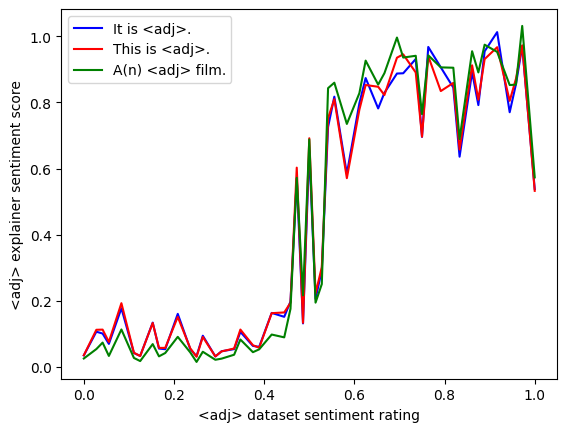

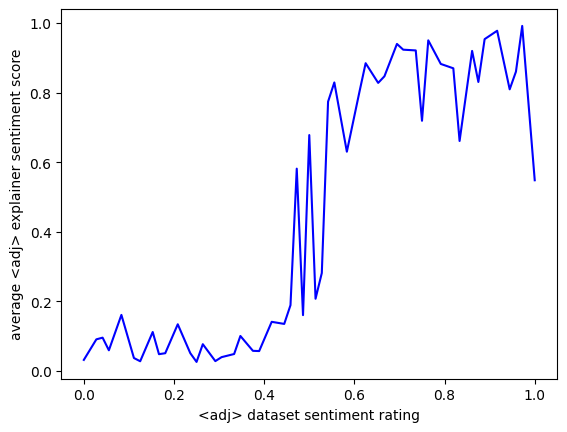

Pearsons correlation (average explainer vs original rating):
pvalue: 0.00000000000000016158532822913317
statistic: 0.86810281302465641672938545525540


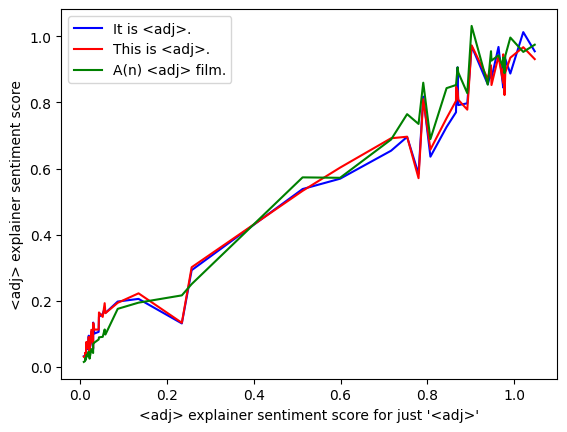

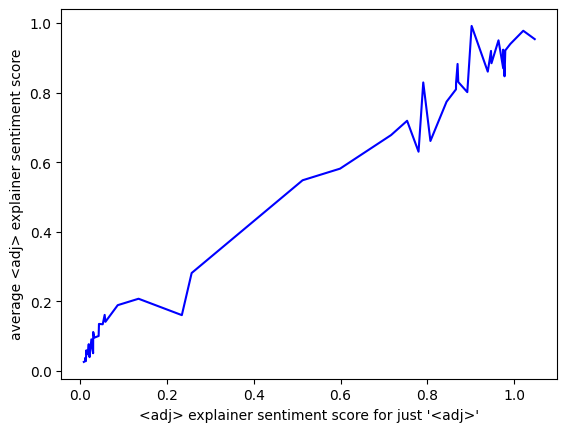

Pearsons correlation (average explainer vs original rating):
pvalue: 0.00000000000000000000000000000000
statistic: 0.99292236256751509326790028353571


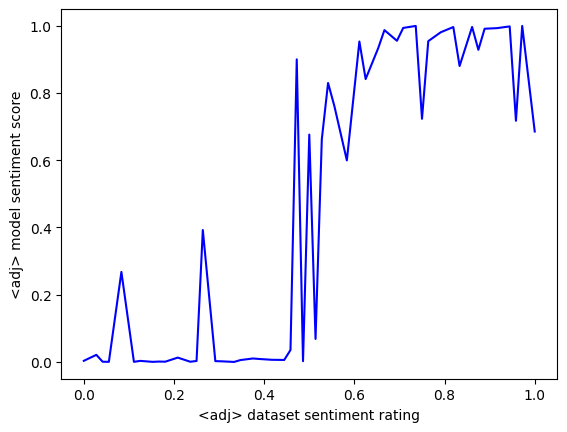

Pearsons correlation (dianna model vs dataset):
pvalue: 0.00000000000000667542994012112219
statistic: 0.84468369642667040508854370273184



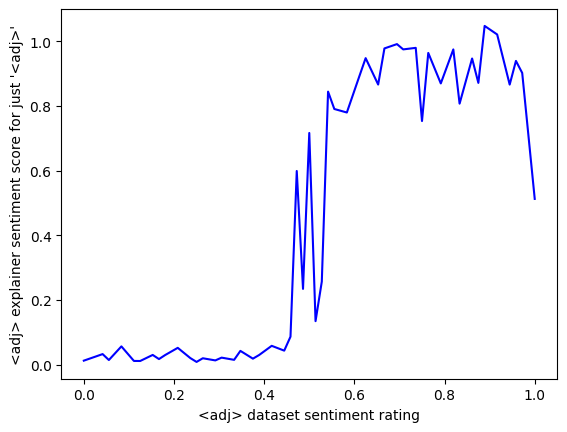

Pearsons correlation (rise explainer vs dataset):
pvalue: 0.00000000000000040633135729260875
statistic: 0.86267834448133928759716582135297



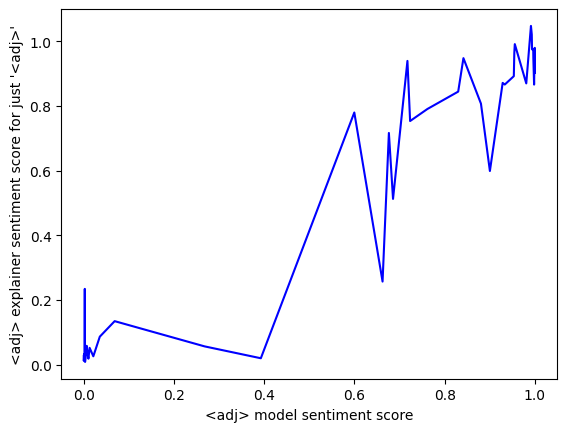

Pearsons correlation (rise explainer vs dianna model):
pvalue: 0.00000000000000000000000000000822
statistic: 0.96388337465229823042278667344362



In [102]:
# graph

print(perturbation1)
print(perturbation2)
print(perturbation3)
print(wordscore)
avgpert=[]

for i in range(len(perturbation1)):
    avgpert.append((perturbation1[i]+perturbation2[i]+perturbation3[i])/3)

plt.plot(wordscore, perturbation1, "-b", label="It is <adj>.")
plt.plot(wordscore, perturbation2, "-r", label="This is <adj>.")
plt.plot(wordscore, perturbation3, "-g", label="A(n) <adj> film.")
plt.legend(loc="upper left")
plt.xlabel("<adj> dataset sentiment rating")
plt.ylabel("<adj> explainer sentiment score")
plt.show()

plt.plot(wordscore, avgpert, "-b")
plt.xlabel("<adj> dataset sentiment rating")
plt.ylabel("average <adj> explainer sentiment score")
plt.show()

corr = pearsonr(wordscore, avgpert)
print('Pearsons correlation (average explainer vs original rating):')
print('pvalue: %.32f' % corr.pvalue)
print('statistic: %.32f' % corr.statistic)

newEWS, newP1 = zip(*sorted(zip(expwordscore,perturbation1)))
newEWS, newP2 = zip(*sorted(zip(expwordscore,perturbation2)))
newEWS, newP3 = zip(*sorted(zip(expwordscore,perturbation3)))

plt.plot(newEWS, newP1, "-b", label="It is <adj>.")
plt.plot(newEWS, newP2, "-r", label="This is <adj>.")
plt.plot(newEWS, newP3, "-g", label="A(n) <adj> film.")
plt.legend(loc="upper left")
plt.xlabel("<adj> explainer sentiment score for just '<adj>'")
plt.ylabel("<adj> explainer sentiment score")
plt.show()

newEWS, newAvgP = zip(*sorted(zip(expwordscore,avgpert)))

plt.plot(newEWS, newAvgP, "-b")
plt.xlabel("<adj> explainer sentiment score for just '<adj>'")
plt.ylabel("average <adj> explainer sentiment score")
plt.show()

corr = pearsonr(expwordscore, avgpert)
print('Pearsons correlation (average explainer vs original rating):')
print('pvalue: %.32f' % corr.pvalue)
print('statistic: %.32f' % corr.statistic)

plt.plot(wordscore, modwordscore[:51], "-b")
plt.xlabel("<adj> dataset sentiment rating")
plt.ylabel("<adj> model sentiment score")
plt.show()

corr = pearsonr(wordscore, modwordscore[:51])
print('Pearsons correlation (dianna model vs dataset):')
print('pvalue: %.32f' % corr.pvalue)
print('statistic: %.32f' % corr.statistic)
print('')

plt.plot(wordscore, expwordscore[:51], "-b")
plt.xlabel("<adj> dataset sentiment rating")
plt.ylabel("<adj> explainer sentiment score for just '<adj>'")
plt.show()

corr = pearsonr(wordscore, expwordscore[:51])
print('Pearsons correlation (rise explainer vs dataset):')
print('pvalue: %.32f' % corr.pvalue)
print('statistic: %.32f' % corr.statistic)
print('')

newMWS, newEWS = zip(*sorted(zip(modwordscore[:51],expwordscore[:51])))

plt.plot(newMWS, newEWS, "-b")
plt.xlabel("<adj> model sentiment score")
plt.ylabel("<adj> explainer sentiment score for just '<adj>'")
plt.show()

corr = pearsonr(modwordscore[:51], expwordscore[:51])
print('Pearsons correlation (rise explainer vs dianna model):')
print('pvalue: %.32f' % corr.pvalue)
print('statistic: %.32f' % corr.statistic)
print('')

In [98]:
newsentence = "A beguiling splash of pastel colors and prankish comedy from Disney."

output_numerical, predicted_class = predict_sentiment(newsentence)
print(f"\"{newsentence}\" - {predicted_class} - {output_numerical:.2f}")

explanation_relevance5 = dianna.explain_text(model_runner, newsentence, model_runner.tokenizer,'RISE', labels=[labels.index('positive')])[0]

for i in range(len(explanation_relevance5)):
    explanation_relevance5[i] = (explanation_relevance5[i][0],explanation_relevance5[i][1],((2*(explanation_relevance5[i][2]))-1))

print(explanation_relevance5)

visualization.highlight_text(explanation_relevance5, model_runner.tokenizer.tokenize(newsentence))

"A beguiling splash of pastel colors and prankish comedy from Disney." - positive - 0.98
Rise parameter p_keep was automatically determined at 0.2


Explaining: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]

[('A', 0, 0.27424614399671565), ('beguiling', 1, 0.7533750998973845), ('splash', 2, 0.5763634398579598), ('of', 3, 0.3359677040576934), ('pastel', 4, 0.5798291957378388), ('colors', 5, 0.5189457410573959), ('and', 6, 0.5108731347322462), ('prankish', 7, 0.34310279563069335), ('comedy', 8, 0.38359620660543436), ('from', 9, 0.05818083316087708), ('Disney', 10, 0.39339916914701445), ('.', 11, 0.28293081164360045)]
